## Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

## Datos

In [ ]:
# Incluyendo CC y la data como viene
# url = 'https://raw.githubusercontent.com/ferdcoz/mcd-ast/original/TP2/Dataset/ST_ATENCION_ORIGNAL.csv'

# Excluyendo CC y sin 0s
url = 'https://raw.githubusercontent.com/ferdcoz/mcd-ast/original/TP2/Dataset/ST_ATENCION.csv'
data = pd.read_csv(url, delimiter=';')
data.head()

,FECHA,WAPP,TP,TAD,PP
0,2022-03-15,19,78,53,9
1,2022-03-16,12,70,26,12
2,2022-03-17,14,66,41,14
3,2022-03-18,67,50,20,9
4,2022-03-21,45,65,44,8


## Metricas

In [ ]:
metrics = pd.DataFrame(columns=['Variable', 'Prophet MSE', 'Prophet RMSE'])

In [ ]:
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%Y-%m-%d')
#data = data.set_index('FECHA')
#data = data.asfreq('B')
#data = data.sort_index()
data.head()

,FECHA,WAPP,TP,TAD,PP
0,2022-03-15,19,78,53,9
1,2022-03-16,12,70,26,12
2,2022-03-17,14,66,41,14
3,2022-03-18,67,50,20,9
4,2022-03-21,45,65,44,8


In [ ]:
data = data.fillna(data.median())

<ipython-input-48-1ed84e2e0a3e>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data = data.fillna(data.median())


In [ ]:
#data_CC = data[['FECHA','CC']]
data_WAPP = data[['FECHA','WAPP']]
data_TP = data[['FECHA','TP']]
data_TAD = data[['FECHA','TAD']]
data_PP = data[['FECHA','PP']]

## WAPP

### Data prep

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = data_WAPP.rename({'FECHA':'ds','WAPP':'y'}, axis='columns')
df.head()

,ds,y
0,2022-03-15,19
1,2022-03-16,12
2,2022-03-17,14
3,2022-03-18,67
4,2022-03-21,45


### Split

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 266 to 379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      114 non-null    datetime64[ns]
 1   y       114 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


### Entranamiento

In [ ]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/l2gepi9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/xbu4gvwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27429', 'data', 'file=/tmp/tmpzbpyrwjb/l2gepi9_.json', 'init=/tmp/tmpzbpyrwjb/xbu4gvwp.json', 'output', 'file=/tmp/tmpzbpyrwjb/prophet_modelc568ud7p/prophet_model-20231203205345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Predicciones

In [ ]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=15, freq='d')

In [ ]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
276,2023-04-25,31.936819,2.828372,61.355197
277,2023-04-26,32.660330,1.875719,63.253568
278,2023-04-27,30.954752,-0.032867,62.294578
279,2023-04-28,29.769232,0.295148,59.522333
280,2023-04-29,24.029624,-6.218046,55.006522


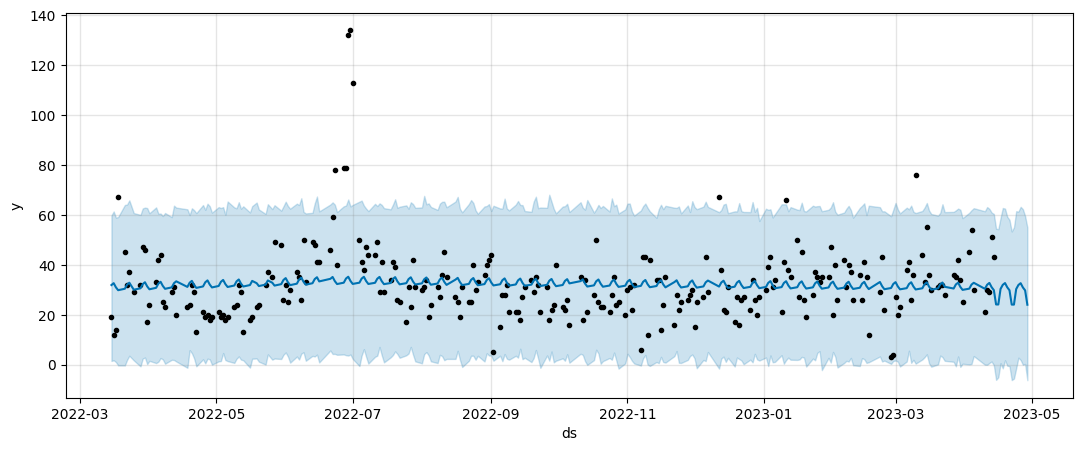

In [ ]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

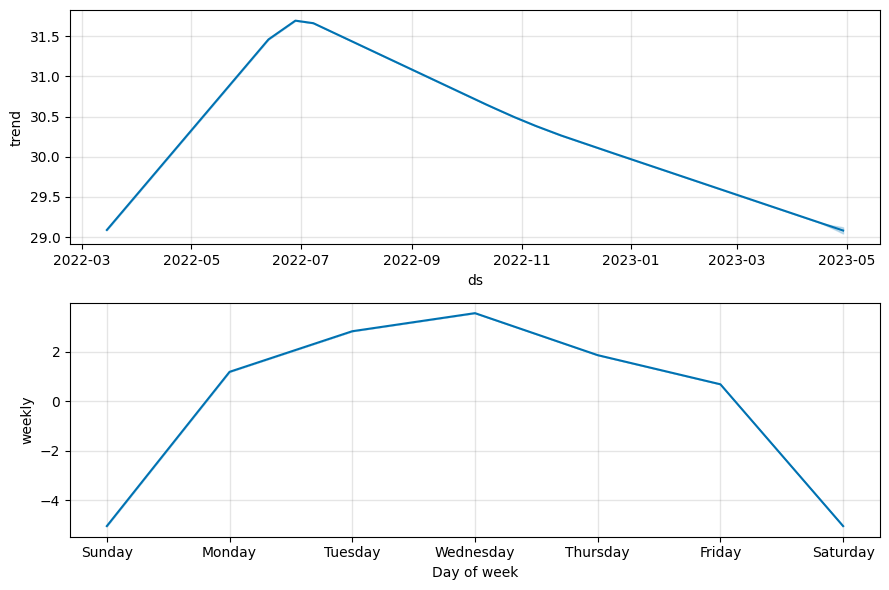

In [ ]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

### Puntos de Cambio

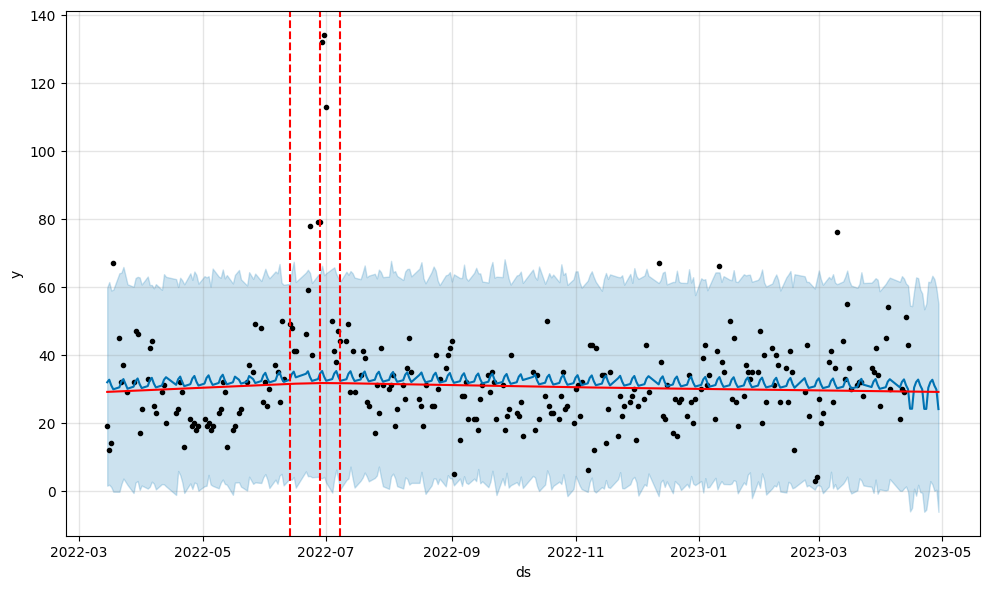

In [ ]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
109,2023-09-25,29.145367,-3.157867,60.796851
110,2023-09-26,30.779576,1.152552,60.792447
111,2023-09-27,31.503087,1.515251,60.014237
112,2023-09-28,29.797509,-0.627941,62.096150
113,2023-09-29,28.611989,-2.096439,59.219453


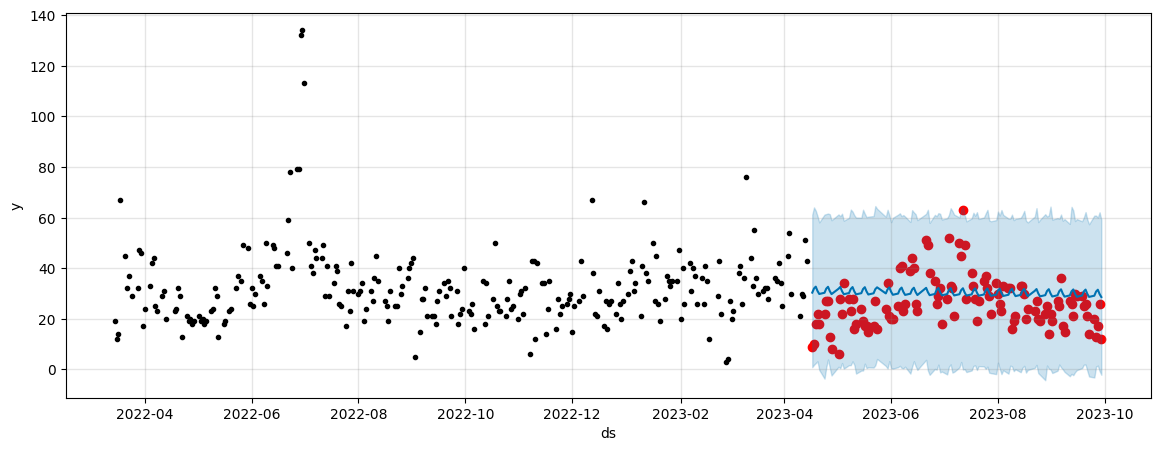

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

### Métricas

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 10.644
Test MSE: 113.298
Test MAE: 8.687
Test R2: -0.157


In [ ]:
metrics = metrics.append({'Variable': 'WAPP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)

<ipython-input-61-690823a066e5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'Variable': 'WAPP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)


In [ ]:
predictions = X_tst_forecast[['ds','yhat']]

## TP

### Data prep

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = data_TP.rename({'FECHA':'ds','TP':'y'}, axis='columns')
df.head()

,ds,y
0,2022-03-15,78
1,2022-03-16,70
2,2022-03-17,66
3,2022-03-18,50
4,2022-03-21,65


### Split

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 266 to 379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      114 non-null    datetime64[ns]
 1   y       114 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


### Entrenamiento

In [ ]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/mk6h716t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/_7ghvmuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1933', 'data', 'file=/tmp/tmpzbpyrwjb/mk6h716t.json', 'init=/tmp/tmpzbpyrwjb/_7ghvmuv.json', 'output', 'file=/tmp/tmpzbpyrwjb/prophet_modelv80urhqf/prophet_model-20231203205346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Predicciones

In [ ]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=15, freq='d')

In [ ]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
276,2023-04-25,184.842171,97.560434,264.534302
277,2023-04-26,175.922183,88.113005,262.300328
278,2023-04-27,183.535122,96.731956,262.271421
279,2023-04-28,173.634389,94.372828,251.495660
280,2023-04-29,183.703055,96.715105,267.764939


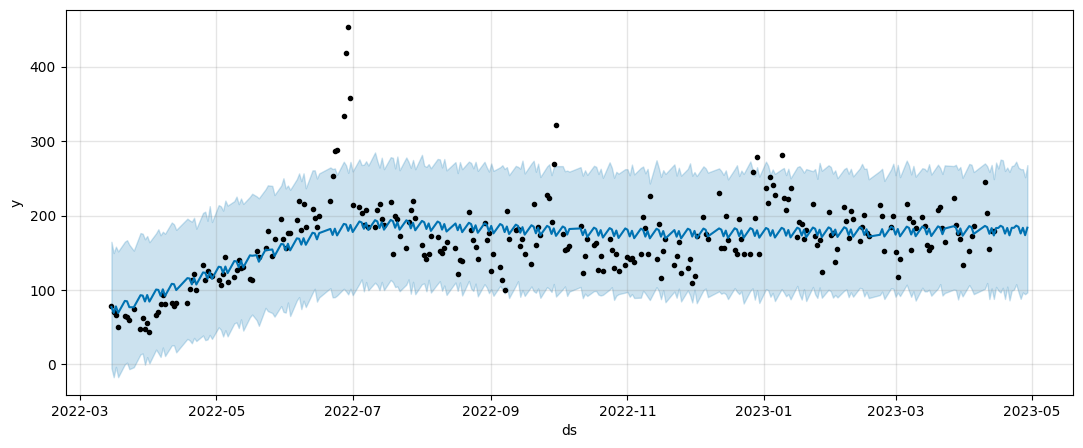

In [ ]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

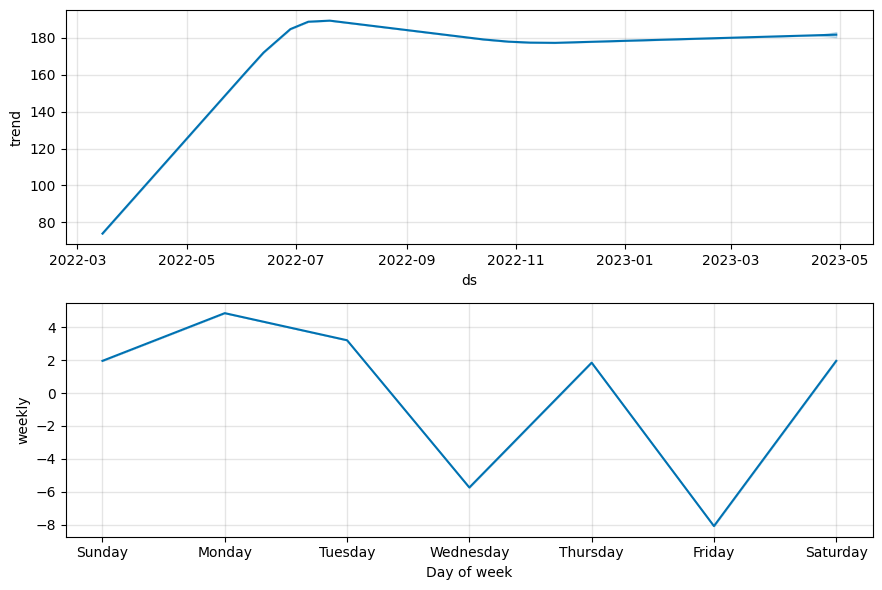

In [ ]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

### Puntos de Cambio

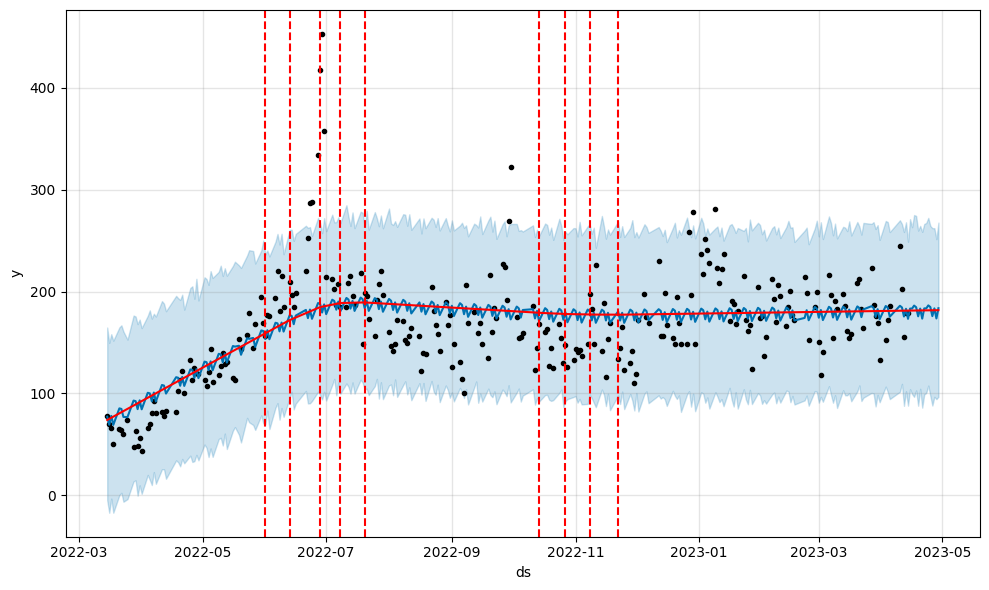

In [ ]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
109,2023-09-25,190.799352,104.555238,286.345410
110,2023-09-26,189.181212,93.198511,287.247258
111,2023-09-27,180.261225,86.528579,273.070251
112,2023-09-28,187.874163,86.992151,278.678415
113,2023-09-29,177.973430,84.579272,270.551860


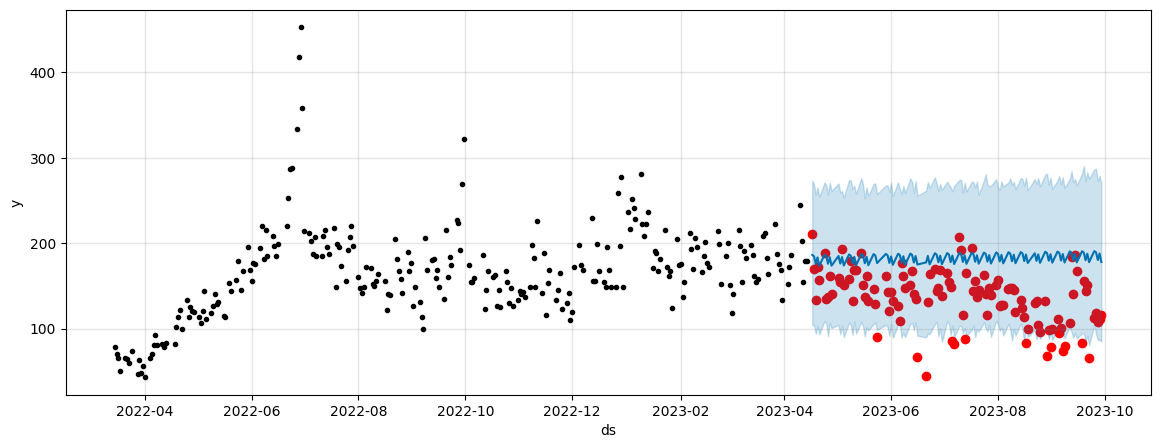

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

### Métricas

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 56.267
Test MSE: 3165.930
Test MAE: 47.336
Test R2: -1.991


In [ ]:
metrics = metrics.append({'Variable': 'TP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)

<ipython-input-74-673d089c9356>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'Variable': 'TP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)


In [ ]:
predictions = pd.concat([predictions, X_tst_forecast[['yhat']]], axis=1, ignore_index=True)

## TAD

### Data prep

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = data_TAD.rename({'FECHA':'ds','TAD':'y'}, axis='columns')
df.head()

,ds,y
0,2022-03-15,53
1,2022-03-16,26
2,2022-03-17,41
3,2022-03-18,20
4,2022-03-21,44


### Split

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 266 to 379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      114 non-null    datetime64[ns]
 1   y       114 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


### Entrenamiento

In [ ]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/cn6zelv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/8t3et22p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71666', 'data', 'file=/tmp/tmpzbpyrwjb/cn6zelv3.json', 'init=/tmp/tmpzbpyrwjb/8t3et22p.json', 'output', 'file=/tmp/tmpzbpyrwjb/prophet_model3v4lqf23/prophet_model-20231203205348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Predicciones

In [ ]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=15, freq='d')

In [ ]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
276,2023-04-25,41.692875,23.536318,59.308302
277,2023-04-26,41.668507,23.849830,59.415789
278,2023-04-27,41.545542,24.129218,59.161180
279,2023-04-28,34.416756,15.197679,52.026249
280,2023-04-29,51.844198,33.951773,70.920880


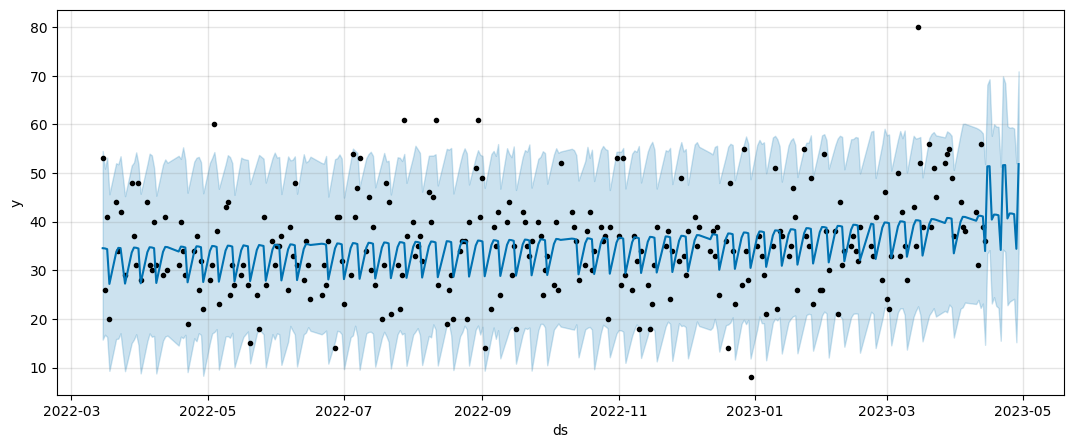

In [ ]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

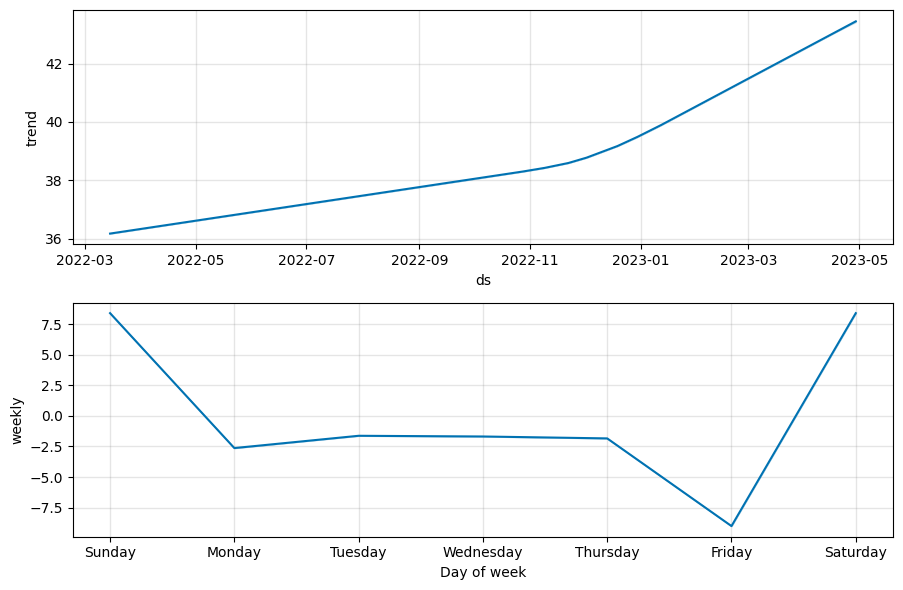

In [ ]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

### Puntos de Cambio

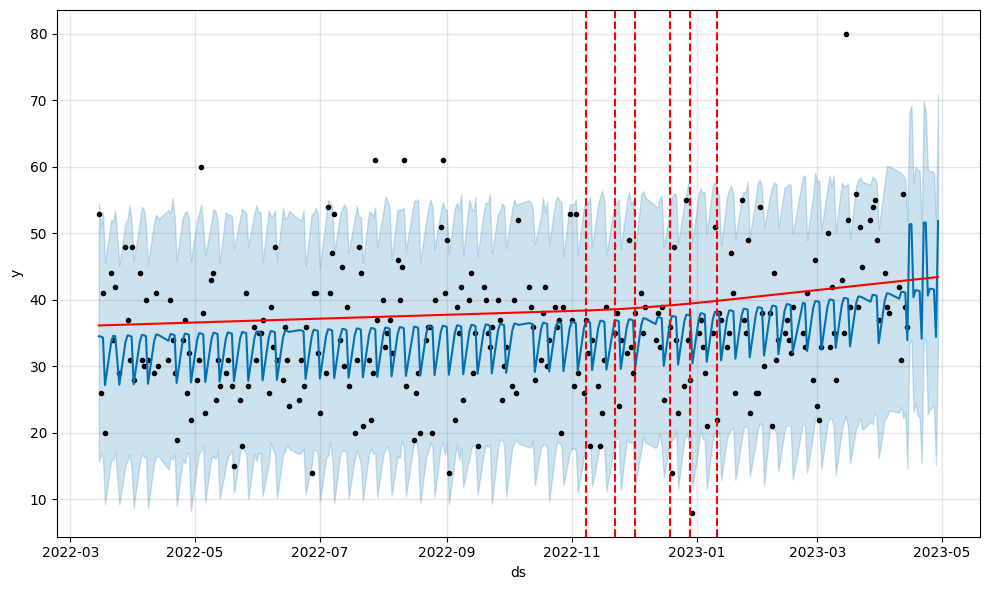

In [ ]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
109,2023-09-25,45.775745,28.315315,64.489536
110,2023-09-26,46.812691,29.355916,65.047945
111,2023-09-27,46.788323,27.686640,64.375171
112,2023-09-28,46.665358,28.270566,65.269459
113,2023-09-29,39.536572,21.567185,57.212480


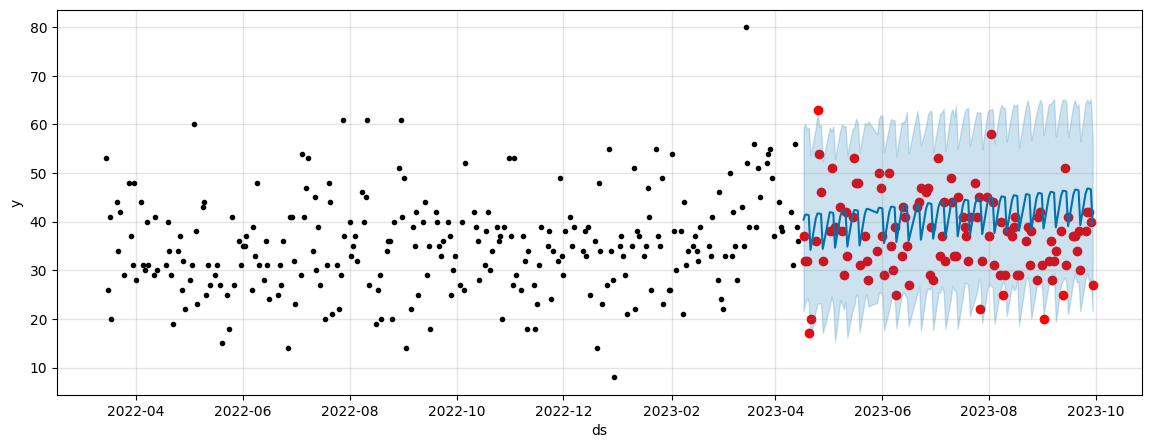

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

### Métricas

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 9.630
Test MSE: 92.736
Test MAE: 7.962
Test R2: -0.391


In [ ]:
metrics = metrics.append({'Variable': 'TAD', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)

<ipython-input-87-c88241c544fe>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'Variable': 'TAD', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)


In [ ]:
predictions = pd.concat([predictions, X_tst_forecast[['yhat']]], axis=1, ignore_index=True)

## PP

### Data prep

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = data_PP.rename({'FECHA':'ds','PP':'y'}, axis='columns')
df.head()

,ds,y
0,2022-03-15,9
1,2022-03-16,12
2,2022-03-17,14
3,2022-03-18,9
4,2022-03-21,8


### Split

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 266 to 379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      114 non-null    datetime64[ns]
 1   y       114 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


### Entrenamiento

In [ ]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/g081ngz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzbpyrwjb/guo13b8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95037', 'data', 'file=/tmp/tmpzbpyrwjb/g081ngz1.json', 'init=/tmp/tmpzbpyrwjb/guo13b8y.json', 'output', 'file=/tmp/tmpzbpyrwjb/prophet_model1uvsxjut/prophet_model-20231203205350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Predicciones

In [ ]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=15, freq='d')

In [ ]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
276,2023-04-25,10.057378,-38.291415,59.292651
277,2023-04-26,13.846488,-30.346982,58.292450
278,2023-04-27,14.714313,-31.840250,58.239445
279,2023-04-28,12.995993,-32.309295,58.254197
280,2023-04-29,2.018648,-41.332384,50.689451


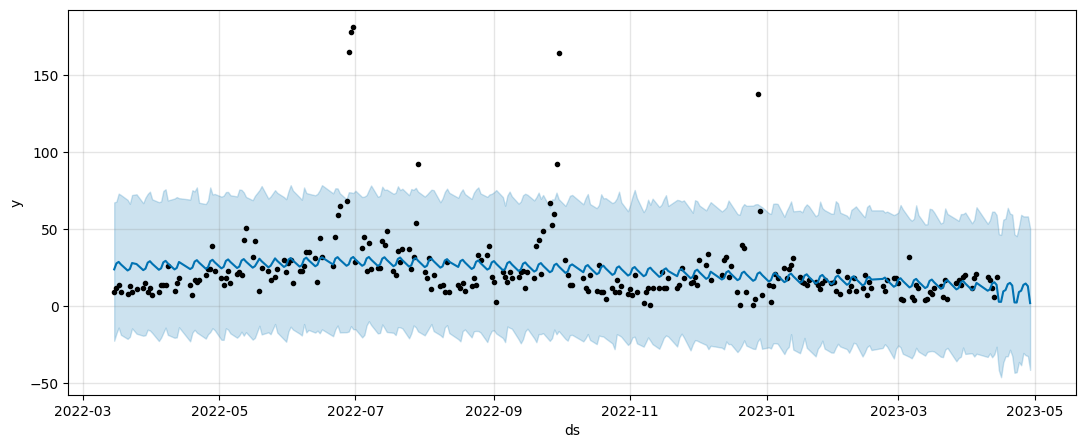

In [ ]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

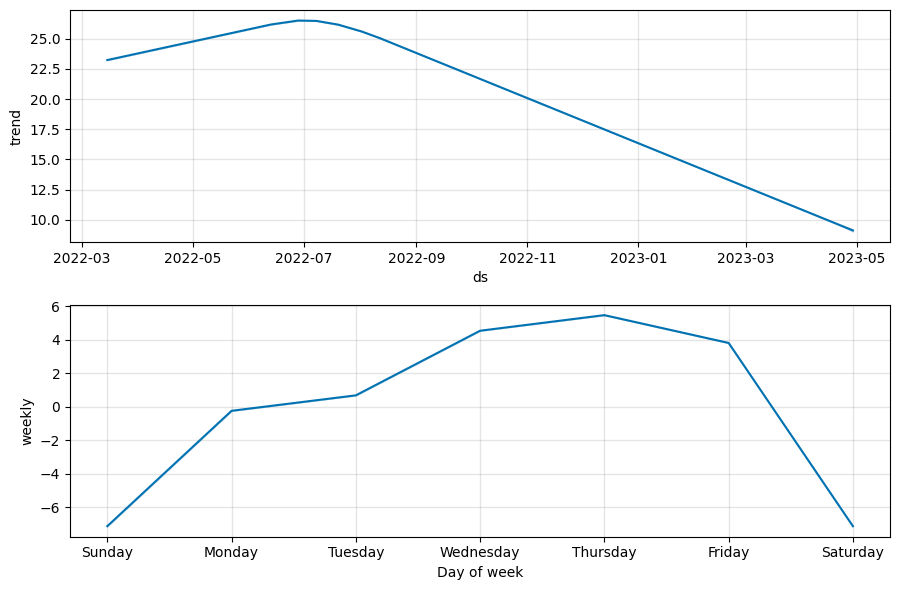

In [ ]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

### Puntos de Cambio

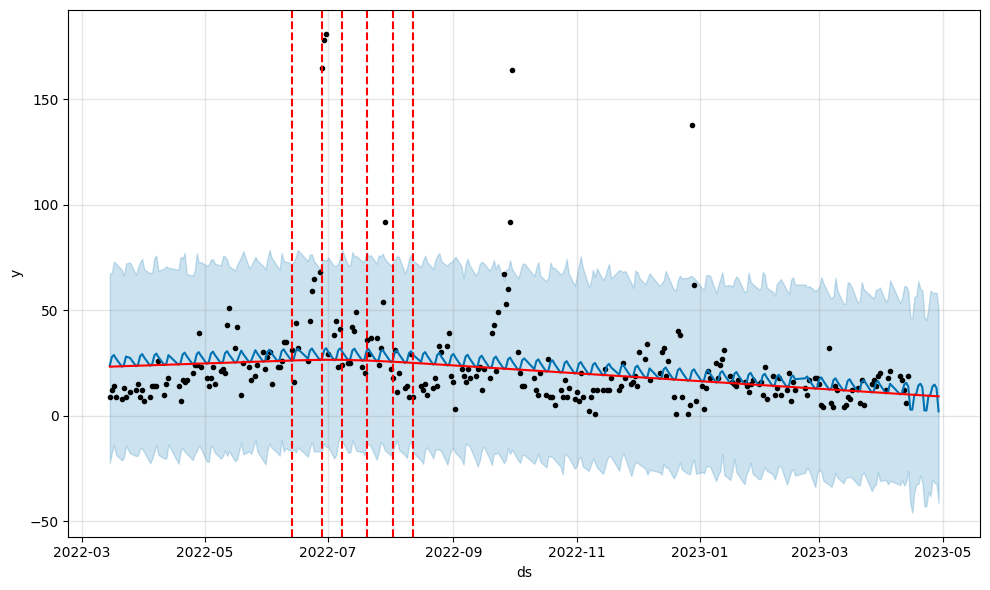

In [ ]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
109,2023-09-25,-0.215841,-48.559977,44.253376
110,2023-09-26,0.643689,-46.222390,43.048133
111,2023-09-27,4.432798,-39.887168,47.257138
112,2023-09-28,5.300623,-39.576458,51.825393
113,2023-09-29,3.582303,-43.137760,54.225304


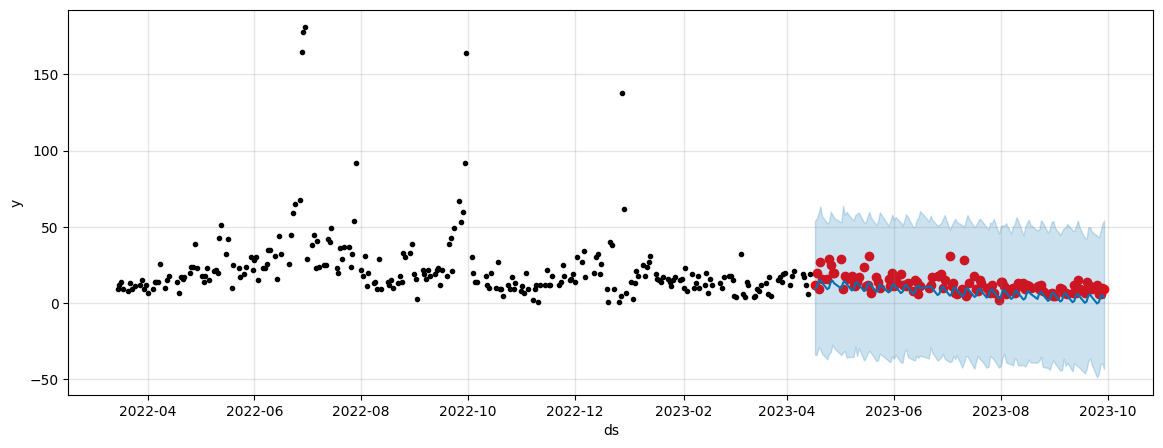

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

### Métricas

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 7.414
Test MSE: 54.966
Test MAE: 5.658
Test R2: -0.617


In [ ]:
metrics = metrics.append({'Variable': 'PP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)

<ipython-input-100-5d3f388fb681>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'Variable': 'PP', 'Prophet MSE': mse, 'Prophet RMSE':rmse}, ignore_index=True)


In [ ]:
predictions = pd.concat([predictions, X_tst_forecast[['yhat']]], axis=1, ignore_index=True)

## Resumen

In [ ]:
metrics.round(2)

,Variable,Prophet MSE,Prophet RMSE
0,WAPP,113.30,10.64
1,TP,3165.93,56.27
2,TAD,92.74,9.63
3,PP,54.97,7.41


## Predicciones

In [ ]:
predictions

,0,1,2,3,4
0,2023-04-17,30.355212,186.263082,40.423210,9.625744
1,2023-04-18,31.989421,184.644942,41.460156,10.485273
2,2023-04-19,32.712932,175.724954,41.435788,14.274383
3,2023-04-20,31.007354,183.337893,41.312823,15.142208
4,2023-04-21,29.821834,173.437160,34.184037,13.423888
...,...,...,...,...,...
109,2023-09-25,29.145367,190.799352,45.775745,-0.215841
110,2023-09-26,30.779576,189.181212,46.812691,0.643689
111,2023-09-27,31.503087,180.261225,46.788323,4.432798
112,2023-09-28,29.797509,187.874163,46.665358,5.300623


In [ ]:
predictions.round(2).to_excel('TP2_preds_prophet.xlsx', index=False)

# Descarga el archivo al sistema local
from google.colab import files
files.download('TP2_preds_prophet.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>